In [3]:
import sys
import os
import importlib
import glob
import random
from itertools import combinations

import numpy as np
import scipy
import sklearn

import shap
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import pytorch_lightning as pl

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
import prettypyplot as pplt

import mdtraj as md

In [2]:
sys.path.insert(1, "../../python")
sys.path.insert(1, "../../..")
import util
import plotting

In [4]:
pplt.load_cmaps()
plt.style.use("custom")  # custom style sheet
plt.style.use("muted")  # muted color theme from SciencePlots
cm_seq = sns.cubehelix_palette(
    start=0, rot=-0.70, gamma=0.40, light=0.9, dark=0.1, as_cmap=True, reverse=True
)
cm_seq2 = sns.cubehelix_palette(
    start=0, rot=-0.70, gamma=0.40, light=0.8, dark=0.1, as_cmap=True, reverse=False
)
colors = mpl.colors.to_rgba_array(
    [
        "#364B9A",
        "#4A7BB7",
        "#6EA6CD",
        "#98CAE1",
        "#C2E4EF",
        "#EAECCC",
        "#FEDA8B",
        "#FDB366",
        "#F67E4B",
        "#DD3D2D",
        "#A50026",
    ]
)
cm_div = mpl.colors.LinearSegmentedColormap.from_list("", colors)

# Load Data

In [5]:
cv_trajs = list(
    np.load("../../data/raw_feat/cv_dist_spin_anton.npy", allow_pickle=True)
)
cv_trajs.extend(np.load("../../data/raw_feat/cv_dist_spin_anton2.npy"))

In [6]:
sb_labels = []
for r in ("R217", "R223", "R226", "R229", "R232"):
    for n in ("D129", "D136", "D151", "D164", "E183", "D186"):
        sb_labels.append(f"{r} - {n}")

In [7]:
sb_trajs = list(np.load("../../data/raw_feat/feat2_raw_anton.npy", allow_pickle=True))
sb_trajs.extend(np.load("../../data/raw_feat/feat2_raw_anton2.npy"))

In [8]:
cv_arr = np.concatenate(cv_trajs)
sb_arr = np.concatenate(sb_trajs)
print(cv_arr.shape, sb_arr.shape)

(4150115, 2) (4150115, 60)


In [9]:
rf161 = list(np.load("../../data/raw_feat/rf161.npy", allow_pickle=True))
rf161.extend(np.load("../../data/raw_feat/rf161_anton2.npy"))
rf161_arr = np.concatenate(rf161)

In [11]:
# load committors
q = np.load("../../data/feat2_dist_du_anton2/qp_downup_3.npy", allow_pickle=True)[
    8
]  # 50 ns
w = np.load(
    "../../data/feat2_dist_du_anton2/weights_3_feat5ivac.npy", allow_pickle=True
)[0]

In [12]:
X = torch.Tensor(np.hstack((cv_arr, sb_arr, rf161_arr)))
y = torch.Tensor(np.concatenate(q)).unsqueeze(-1)
print(X.shape, y.shape)

torch.Size([4150115, 65]) torch.Size([4150115, 1])


In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [14]:
class MultiLayerNet(pl.LightningModule):
    """Neural network with a multiple hidden layers
    and sigmoid activation.

    Parameters
    ----------
    """

    def __init__(
        self, input_dim, hidden_dim=30, output_dim=1, n_hidden=5, verbose=True
    ):
        super(MultiLayerNet, self).__init__()
        layers = []
        layers.append(nn.Linear(input_dim, hidden_dim))
        layers.append(nn.ReLU())
        for _ in range(n_hidden):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(hidden_dim, output_dim))
        layers.append(nn.Sigmoid())
        self.net = nn.Sequential(*layers)
        self.verbose = verbose

    def forward(self, x):
        return self.net(x)

    def training_step(self, batch, batch_idx):
        X, y = batch
        # Compute prediction and loss
        pred = self.net(X)
        loss = F.mse_loss(pred, y)

        if self.verbose:
            # if batch_idx % 100 == 0:
            #     loss, current = loss.item(), batch * len(X)
            #     print(f"loss: {loss:>7f}  [{current:>5d}/]")
            self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=4e-3)
        return optimizer
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        pred = self.net(x)
        loss = F.mse_loss(pred, y)
        self.log("val_loss", loss)
        
    def test_step(self, batch, batch_idx):
        x, y = batch
        pred = self.net(x)
        loss = F.mse_loss(pred, y)
        return loss

In [15]:
input_dim = X.shape[-1]
hidden_dim = 30
n_layers = 3
mlp = MultiLayerNet(input_dim, hidden_dim=hidden_dim, n_hidden=n_layers)

In [16]:
# 80/15/5 train/val/test split
train_X, val_X, train_y, val_y = sklearn.model_selection.train_test_split(
    X, y, test_size=0.2, random_state=123
)
val_X, test_X, val_y, test_y = sklearn.model_selection.train_test_split(val_X, val_y, test_size=0.25, random_state=123)
print(train_X.shape, val_X.shape, test_X.shape, train_y.shape, val_y.shape, test_y.shape)

torch.Size([3320092, 65]) torch.Size([622517, 65]) torch.Size([207506, 65]) torch.Size([3320092, 1]) torch.Size([622517, 1]) torch.Size([207506, 1])


In [18]:
class CommittorDataset(Dataset):
    def __init__(self, data, q):
        self.data = data
        self.q = q

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return (self.data[idx], self.q[idx])

In [19]:
batch_size = 16384
train_dataset = CommittorDataset(train_X, train_y)
train_batches = DataLoader(train_dataset, batch_size=batch_size, num_workers=48)
val_dataset = CommittorDataset(val_X, val_y)
val_batches = DataLoader(val_dataset, batch_size=batch_size, num_workers=48)
test_dataset = CommittorDataset(test_X, test_y)
test_batches = DataLoader(test_dataset, batch_size=batch_size, num_workers=48)

In [22]:
trainer = pl.Trainer(max_epochs=100)
trainer.fit(model=mlp, train_dataloader=train_batches, val_dataloaders=val_batches)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Set SLURM handle signals.

  | Name | Type       | Params
------------------------------------
0 | net  | Sequential | 4.8 K 
------------------------------------
4.8 K     Trainable params
0         Non-trainable params
4.8 K     Total params
0.019     Total estimated model params size (MB)


Epoch 0:  84%|████████▍ | 203/241 [00:25<00:04,  8.06it/s, loss=0.00168, v_num=3887854, train_loss_step=0.00166]
Validating: 0it [00:00, ?it/s]
Epoch 1:  84%|████████▍ | 203/241 [00:24<00:04,  8.23it/s, loss=0.00111, v_num=3887854, train_loss_step=0.00104, train_loss_epoch=0.00724]
Validating: 0it [00:00, ?it/s]
Epoch 2:  84%|████████▍ | 203/241 [00:25<00:04,  7.87it/s, loss=0.000891, v_num=3887854, train_loss_step=0.000872, train_loss_epoch=0.00132]
Validating: 0it [00:00, ?it/s]
Epoch 3:  84%|████████▍ | 203/241 [00:24<00:04,  8.44it/s, loss=0.000844, v_num=3887854, train_loss_step=0.000791, train_loss_epoch=0.00116]
Validating: 0it [00:00, ?it/s]
Epoch 4:  84%|████████▍ | 203/241 [00:25<00:04,  8.06it/s, loss=0.000735, v_num=3887854, train_loss_step=0.00071, train_loss_epoch=0.000936] 
Validating: 0it [00:00, ?it/s]
Epoch 5:  84%|████████▍ | 203/241 [00:25<00:04,  8.08it/s, loss=0.00082, v_num=3887854, train_loss_step=0.000801, train_loss_epoch=0.000836] 
Validating: 0it [00:00, ?it

In [23]:
trainer.test(mlp, test_batches)

Testing: 100%|██████████| 13/13 [00:01<00:00,  9.89it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 13/13 [00:01<00:00,  7.28it/s]


[{}]

In [24]:
mse = 0
for X, y in iter(test_batches):
    pred = mlp(X)
    with torch.no_grad():
        mse += F.mse_loss(y, pred)
mse /= len(test_batches)
print(f"MSE: {mse:.3e} / RMSE: {np.sqrt(mse):.<3f}")

MSE: 3.176e-04 / RMSE: 0.017822


# SHAP values

In [26]:
X = torch.Tensor(np.hstack((cv_arr, sb_arr, rf161_arr)))
y = torch.Tensor(np.concatenate(q)).unsqueeze(-1)
print(X.shape, y.shape)

torch.Size([4150115, 65]) torch.Size([4150115, 1])


In [29]:
cutoff = 0.2
q_arr = np.concatenate(q)
mid_idx = ((q_arr > cutoff) & (q_arr < 1 - cutoff)).nonzero()[0]
X_trans = X[mid_idx]
y_trans = y[mid_idx]

In [30]:
print(X_trans.shape)

torch.Size([1282655, 65])


In [31]:
X1000 = shap.utils.sample(X_trans, 1000)

In [32]:
e = shap.DeepExplainer(mlp, X1000)

In [33]:
shap_values_de = e.shap_values(X_trans[::100])

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


In [31]:
np.save("deep_exp_shap_skip100_trans", shap_values_de)

In [35]:
feature_names = []
feature_names.append('Translocation')
feature_names.append('Rotation')
for r in ("R217", "R223", "R226", "R229", "R232"):
    for n in ("D129", "D136", "D151", "D164", "E183", "D186"):
        feature_names.append(f"{r} C$_\\alpha$—{n} C$_\\alpha$")
for r in ("R217", "R223", "R226", "R229", "R232"):
    for n in ("D129", "D136", "D151", "D164", "E183", "D186"):
        if n.startswith("D"):
            feature_names.append(f"{r} C$_\\zeta$—{n} C$_\\gamma$")
        else:
            feature_names.append(f"{r} C$_\\zeta$—{n} C$_\\varepsilon$")
for i in ("R223", "R226", "R229"):
    feature_names.append(f"{i}—F161")

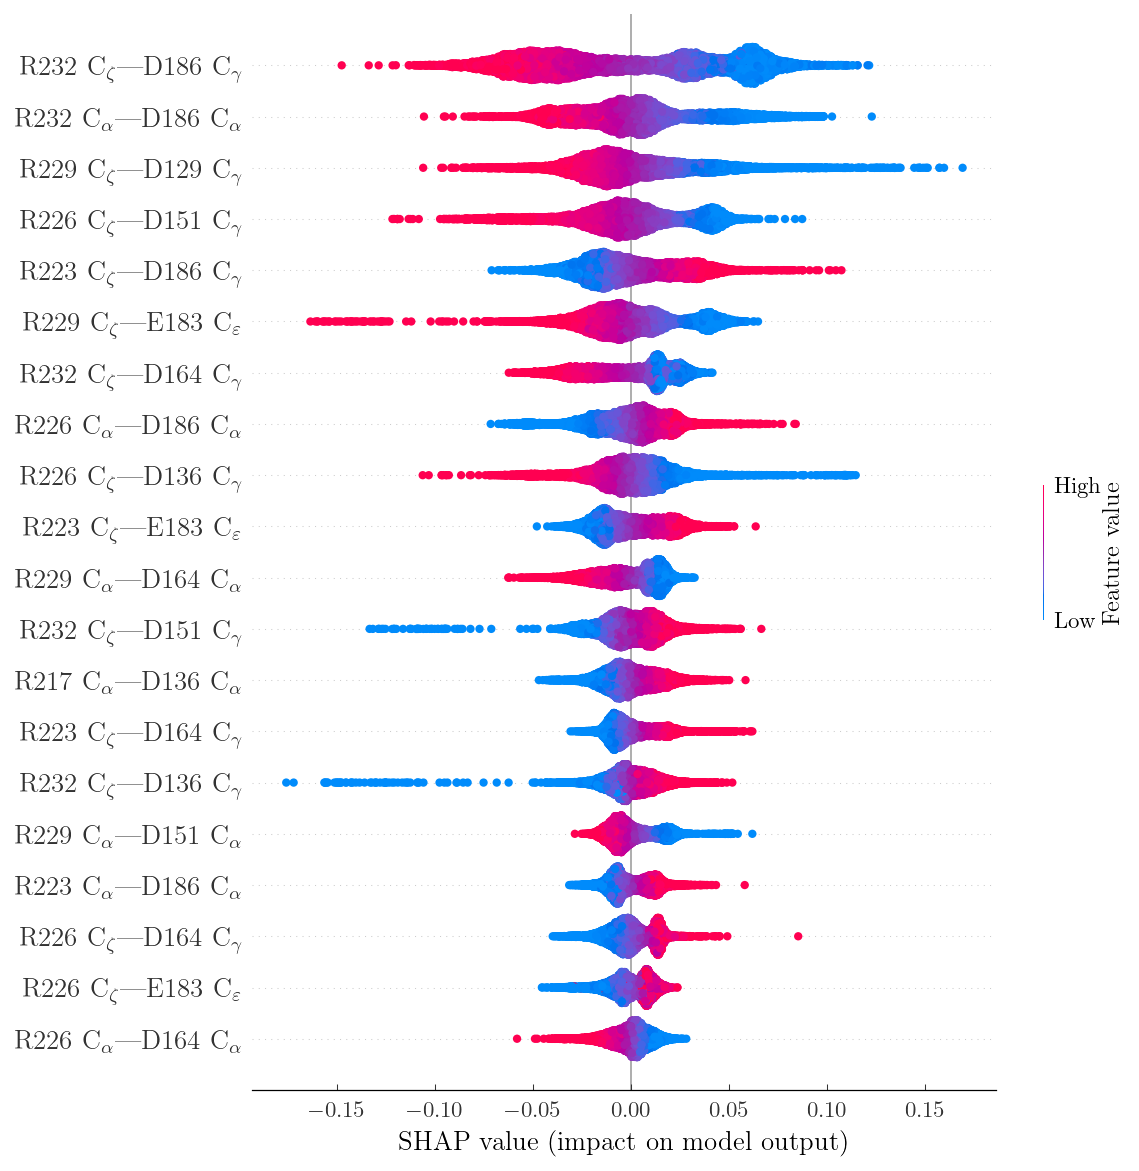

In [36]:
shap.summary_plot(shap_values_de, X_trans[::100], feature_names)